In [1]:
import os
import torch
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

sys.path.insert(0, './src')
%matplotlib inline
from metrics import NDCG_binary_at_k_batch, Recall_at_k_batch
from models import MultiVAE, MultiDAE, Multi_our_VAE, MultiHoffmanVAE, Multi_ourHoffman_VAE
from training import train_met_model
from args import get_args
from kernels import HMC_our, Reverse_kernel
import numpy as np
import pandas as pd

sys.path.insert(0, '../')
from target import GMM_target2

import pdb

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [2]:
args = dotdict({})

args.device = 'cuda:0'
L = 2
z_dim = 32
K = 64

print_info_ = 500

args.train_batch_size = 500
args.n_epoches = 2001

In [3]:
# 'Encoder' - simple matrix
class Encoder_vae(nn.Module):
    def __init__(self, L, z_dim):
        super(Encoder_vae, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.h1 = nn.Linear(in_features=self.L, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=self.z_dim)
        self.sigma = nn.Linear(in_features=K, out_features=self.z_dim)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        return self.mu(h1), F.softplus(self.sigma(h1))
    
class Decoder_vae(nn.Module):
    def __init__(self, L, z_dim):
        super(Decoder_vae, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.h1 = nn.Linear(in_features=self.z_dim, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=self.L)
#         self.sigma = nn.Linear(in_features=K, out_features=self.L)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        return self.mu(h1) #, nn.functional.softplus(self.sigma(h3))

In [4]:
# GMM with arbitraty many components
comp_1 = 1.
comp_2 = 0.7
args['num_gauss'] = 8
args['p_gaussians'] = [torch.tensor(1. / args['num_gauss'], device=args.device, dtype=args.torchType)] * args['num_gauss']
args['locs'] = [torch.tensor([0., comp_1], dtype=args.torchType, device=args.device),
               torch.tensor([comp_2, comp_2], dtype=args.torchType, device=args.device),
               torch.tensor([comp_1, 0.], dtype=args.torchType, device=args.device),
               torch.tensor([comp_2, -comp_2], dtype=args.torchType, device=args.device),
               torch.tensor([0., -comp_1], dtype=args.torchType, device=args.device),
               torch.tensor([-comp_2, -comp_2], dtype=args.torchType, device=args.device),
               torch.tensor([-comp_1, 0.], dtype=args.torchType, device=args.device),
               torch.tensor([-comp_2, comp_2], dtype=args.torchType, device=args.device)]  # list of locations for each of these gaussians
args['covs'] = [0.01 * torch.eye(2, dtype=args.torchType, device=args.device)] * args['num_gauss']   # list of covariance matrices for each of these

target = GMM_target2(args)
data = target.get_samples(1000)

In [5]:
dataloader = torch.utils.data.DataLoader(data, batch_size=args.train_batch_size, shuffle=True)

## VAE

  0%|          | 0/2001 [00:00<?, ?it/s]

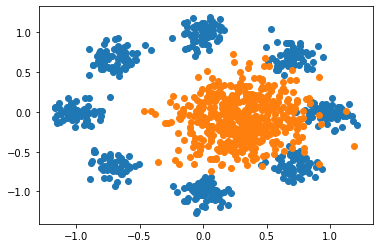

elbo: -1.390976071357727


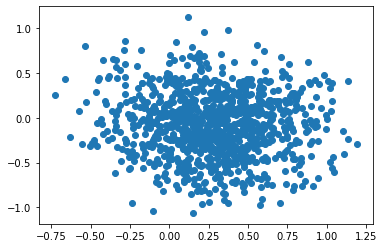

 25%|██▍       | 500/2001 [00:04<00:14, 102.65it/s]

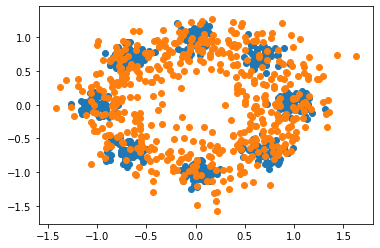

elbo: -1.0150126218795776


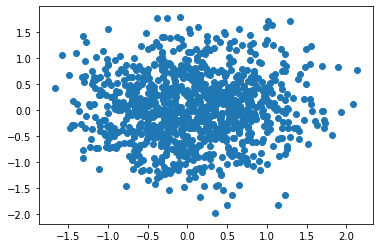

 50%|████▉     | 993/2001 [00:09<00:09, 110.15it/s]

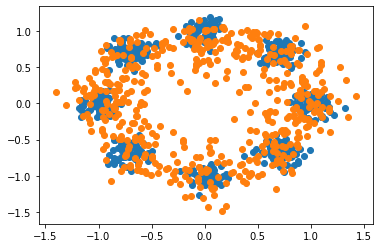

elbo: -1.0121372938156128


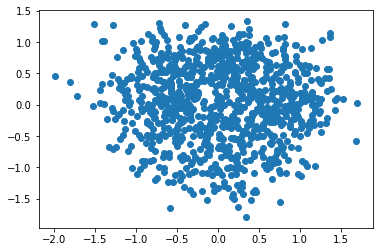

 75%|███████▍  | 1500/2001 [00:14<00:04, 111.69it/s]

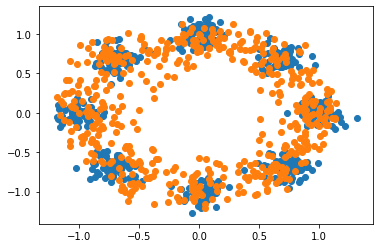

elbo: -1.007319688796997


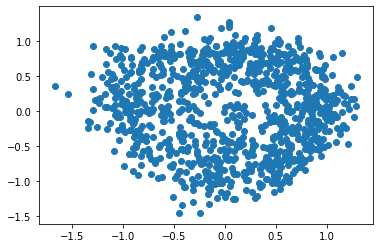

100%|█████████▉| 1995/2001 [00:18<00:00, 109.65it/s]

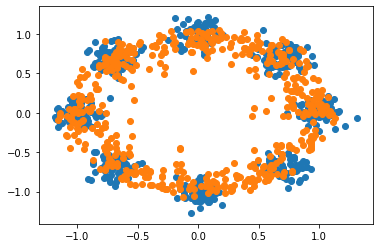

elbo: -1.006271481513977


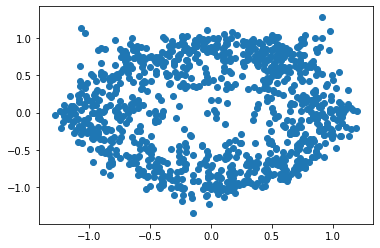

100%|██████████| 2001/2001 [00:18<00:00, 106.01it/s]


In [6]:
enc = Encoder_vae(L=L, z_dim=z_dim).to(args.device)
dec = Decoder_vae(L=L, z_dim=z_dim).to(args.device)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=args.device),
                                                scale=torch.tensor(1., device=args.device))
args.std_normal = std_normal

params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params=params, lr=1e-3)
for ep in tqdm(range(args.n_epoches)): # cycle over epoches
    plt.close()
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
#         pdb.set_trace()   
        mu, sigma = enc(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + u * sigma # reperametrization trick
        
        mu_recovered = dec(z)
        
#         ##### Works
        log_likelihood = torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).mean()
        sum_log_sigma = torch.log(sigma)
        log_prior = std_normal.log_prob(z)
        log_q = std_normal.log_prob(u) - sum_log_sigma
        KLD = (-log_prior + log_q).mean()
#         KLD = -0.5 * torch.mean(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))
        elbo = log_likelihood - KLD
    
        ##### DOESNOT Work
#         log_likelihood = torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).sum(1)
#         sum_log_sigma = torch.log(sigma).sum(1)
#         log_prior = std_normal.log_prob(z).sum(1)
#         log_q = std_normal.log_prob(u).sum(1) - sum_log_sigma
#         KLD = -log_prior + log_q
#         KLD = -0.5 * (1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2)).sum(1)
#         elbo = (log_likelihood - KLD).mean()


        (-elbo).backward()
        
        optimizer.step()
        optimizer.zero_grad()
#     scheduler.step(elbo)
    if ep % print_info_ == 0:
        plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1])
        plt.scatter(mu_recovered.cpu().detach().numpy()[:, 0], mu_recovered.cpu().detach().numpy()[:, 1])
        plt.show()
        print('elbo:', elbo.cpu().detach().item())
        
        z = np.random.randn(1000, 32).astype(np.float32)
        ds = dec(torch.tensor(z, device=args.device)).cpu().detach().numpy()
        plt.scatter(ds[:, 0], ds[:, 1])
        plt.show();

## MetVAE

In [7]:
args.n_epoches = 20001
print_info_ = 2000

args.torchType = torch.float32

args.annealing = False
args.learnable_reverse = False
args.learntransitions = False

## Transition parameters (only for our vae)
if args.learntransitions:
    args.gamma = 0.1
    # args.alpha = 0.5
else:
    args.gamma = 0.01  # Stepsize
args.alpha = 0.9  #0.5  # For partial momentum refresh
args.use_barker = True
args.use_partialref = True

args.K = 2
args.N = 2
args.z_dim = z_dim

args.lrenc = 1e-3
args.lrdec = 1e-3

args.l2_coeff = 0.

if args.annealing:
    args.total_anneal_steps = 46000
else:
    args.total_anneal_steps = 0
    args.anneal_cap = 1.

In [8]:
class Target(nn.Module):
    def __init__(self, dec, device='cpu'):
        super(Target, self).__init__()
        self.decoder = dec
        self.prior = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                                scale=torch.tensor(1., device=device, dtype=torch.float32))

    def get_logdensity(self, x, z, prior=None, args=None, prior_flow=None):
        """
        The method returns target logdensity
        Input:
        x - datapoint
        z - latent vaiable
        Output:
        log_density - log p(x, z)
        """
        mu_recovered = self.decoder(z)
        log_density = torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(x).sum(1) + self.prior.log_prob(z).sum(1)
        return log_density

In [9]:
class Multi_our_VAE(nn.Module):
    def __init__(self, encoder, decoder, args=None):
        super(Multi_our_VAE, self).__init__()

        ## Define encoder
        self.encoder = encoder(L=L, z_dim=z_dim)
        print(self.encoder)

        ## Define target(decoder)
        decoder = decoder(L=L, z_dim=z_dim)
        print(decoder)
        self.target = Target(dec=decoder, device=args.device)

        ## Define transitions
        self.K = args.K
        self.transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])

        ## Define reverse kernel (if it is needed)
        self.learnable_reverse = args.learnable_reverse
        if args.learnable_reverse:
            self.reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)

#         self.dropout = nn.Dropout()

        device_zero = torch.tensor(0., dtype=torch.float32, device=args.device)
        device_one = torch.tensor(1., dtype=torch.float32, device=args.device)
        self.std_normal = torch.distributions.Normal(loc=device_zero, scale=device_one)
        self.torch_log_2 = torch.tensor(np.log(2), device=args.device, dtype=args.torchType)

    def forward(self, x):
        mu, std = self.encoder(x)
        sum_log_alpha = torch.zeros_like(mu[:, 0])
        sum_log_jacobian = torch.zeros_like(mu[:, 0])

        u = self.std_normal.sample(mu.shape)
        z = mu + u * std

        p_old = self.std_normal.sample(z.shape)
        p_ = p_old.detach()

        all_directions = torch.tensor([], device=x.device)

        for i in range(self.K):
            cond_vector = self.std_normal.sample(p_.shape)
            z, p_, log_jac, current_log_alphas, directions, _ = self.transitions[i].make_transition(q_old=z, x=x,
                                                                                                    p_old=p_,
                                                                                                    k=cond_vector,
                                                                                                    target_distr=self.target)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac
            all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)

        ## logdensity of Variational family
        log_sigma = torch.log(std)
        log_q = self.std_normal.log_prob(u) + self.std_normal.log_prob(p_old) - log_sigma
        log_aux = -sum_log_jacobian + sum_log_alpha

        ## logdensity of prior
        log_priors = self.std_normal.log_prob(z) + self.std_normal.log_prob(p_)

        ## logits
        mu_recovered = self.target.decoder(z)

        ## logdensity of reverse (if needed)
        if self.learnable_reverse:
            log_r = self.reverse_kernel(z_fin=z.detach(), h=mu.detach(), a=all_directions)
        else:
            log_r = -self.K * self.torch_log_2

        return mu_recovered, log_q, log_aux, log_priors, log_r, sum_log_alpha, all_directions

In [10]:
model = Multi_our_VAE(encoder=Encoder_vae, decoder=Decoder_vae, args=args).to(args.device)

Encoder_vae(
  (h1): Linear(in_features=2, out_features=64, bias=True)
  (mu): Linear(in_features=64, out_features=32, bias=True)
  (sigma): Linear(in_features=64, out_features=32, bias=True)
)
Decoder_vae(
  (h1): Linear(in_features=32, out_features=64, bias=True)
  (mu): Linear(in_features=64, out_features=2, bias=True)
)


  0%|          | 0/20001 [00:00<?, ?it/s]

k = 0
0: 0.5060000240337104 and for +1: 0.49400002346374094
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------
k = 1
0: 0.5220000247936696 and for +1: 0.4780000227037817
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------


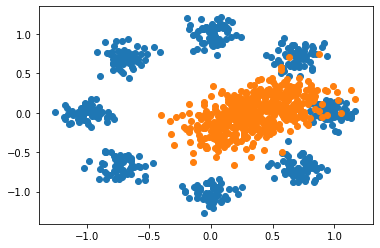

elbo: -8.16285514831543


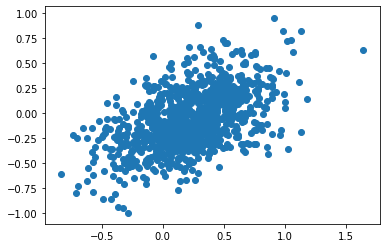

 10%|▉         | 2000/20001 [01:12<11:20, 26.47it/s]

k = 0
0: 0.5040000239387155 and for +1: 0.49600002355873585
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------
k = 1
0: 0.5100000242237002 and for +1: 0.49000002327375114
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------


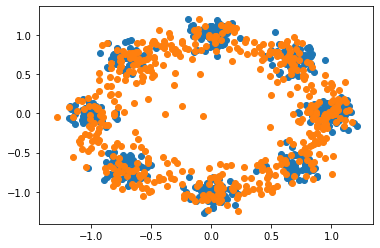

elbo: -7.753809928894043


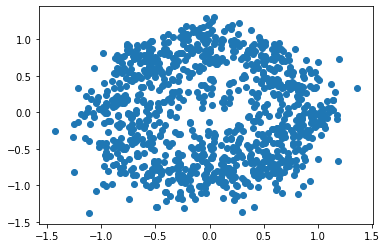

 20%|█▉        | 3999/20001 [02:25<09:16, 28.74it/s]

k = 0
0: 0.5000000237487257 and for +1: 0.5000000237487257
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------
k = 1
0: 0.5320000252686441 and for +1: 0.4680000222288072
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------


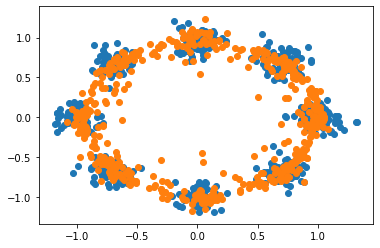

elbo: -7.748658180236816


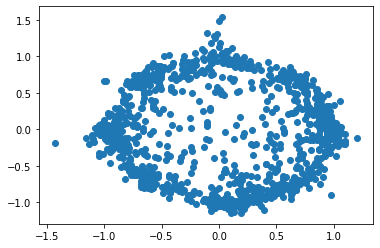

 30%|██▉       | 5999/20001 [03:39<08:26, 27.63it/s]

k = 0
0: 0.5040000239387155 and for +1: 0.49600002355873585
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------
k = 1
0: 0.5020000238437206 and for +1: 0.49800002365373075
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------


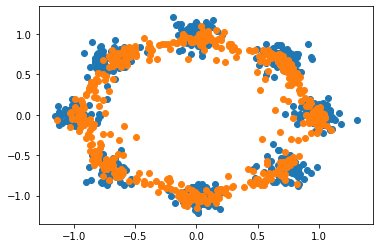

elbo: -7.7467169761657715


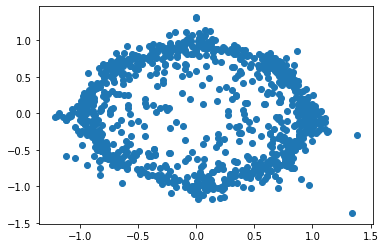

 40%|███▉      | 7999/20001 [04:52<07:32, 26.53it/s]

k = 0
0: 0.48400002298876643 and for +1: 0.5160000245086849
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------
k = 1
0: 0.5040000239387155 and for +1: 0.49600002355873585
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------


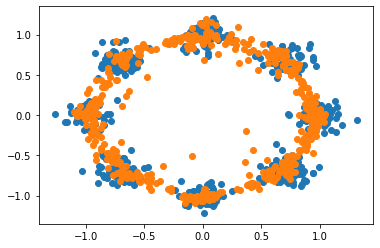

elbo: -7.747701644897461


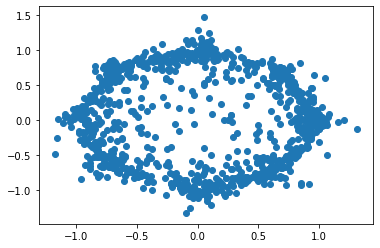

 50%|████▉     | 9997/20001 [06:06<06:01, 27.69it/s]

k = 0
0: 0.49200002336874604 and for +1: 0.5080000241287053
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------
k = 1
0: 0.5260000249836594 and for +1: 0.4740000225137919
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------


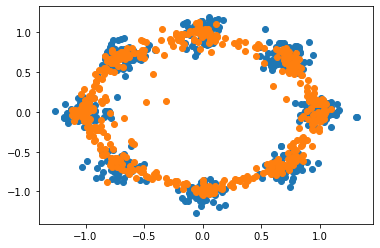

elbo: -7.744807243347168


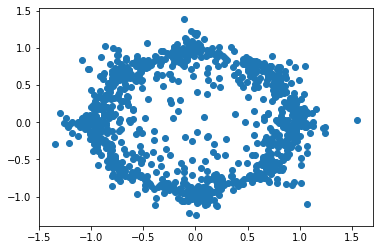

 60%|█████▉    | 12000/20001 [07:20<05:38, 23.64it/s]

k = 0
0: 0.5160000245086849 and for +1: 0.48400002298876643
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------
k = 1
0: 0.5100000242237002 and for +1: 0.49000002327375114
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------


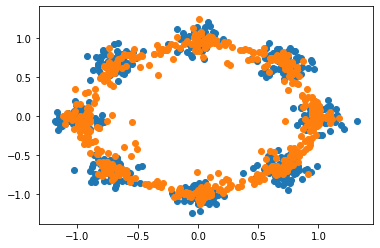

elbo: -7.7471795082092285


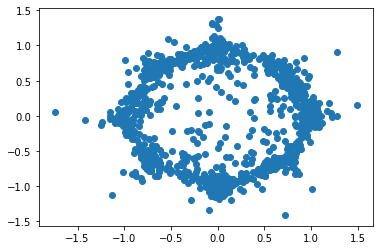

 70%|██████▉   | 13998/20001 [08:34<03:39, 27.30it/s]

k = 0
0: 0.5320000252686441 and for +1: 0.4680000222288072
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------
k = 1
0: 0.5040000239387155 and for +1: 0.49600002355873585
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------


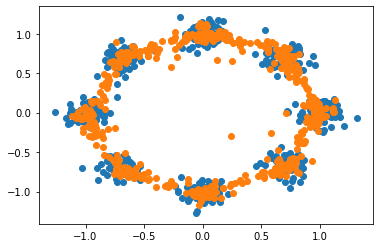

elbo: -7.749368667602539


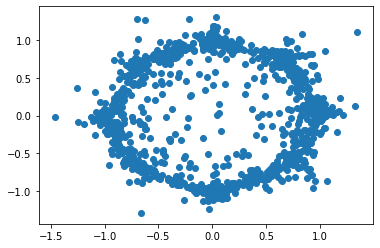

 80%|███████▉  | 16000/20001 [09:48<02:29, 26.83it/s]

k = 0
0: 0.51400002441369 and for +1: 0.48600002308376133
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------
k = 1
0: 0.5000000237487257 and for +1: 0.5000000237487257
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------


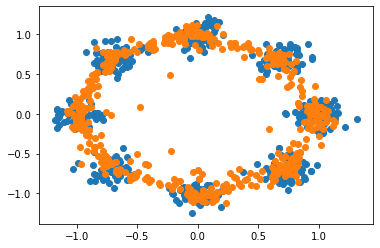

elbo: -7.746401786804199


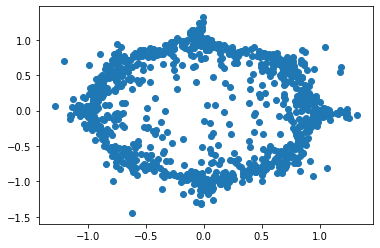

 90%|████████▉ | 17998/20001 [11:03<01:13, 27.40it/s]

k = 0
0: 0.5220000247936696 and for +1: 0.4780000227037817
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------
k = 1
0: 0.5080000241287053 and for +1: 0.49200002336874604
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------


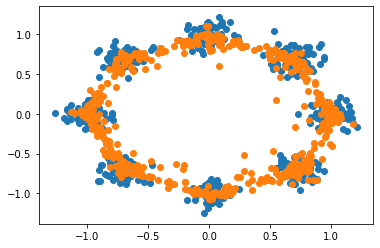

elbo: -7.74677038192749


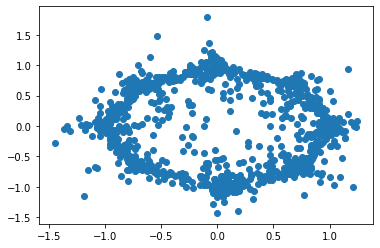

100%|█████████▉| 19999/20001 [12:16<00:00, 29.13it/s]

k = 0
0: 0.49400002346374094 and for +1: 0.5060000240337104
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------
k = 1
0: 0.5260000249836594 and for +1: 0.4740000225137919
autoreg: 0.8999999761581421
stepsize 0.009999999776482582
----------------------------------------------------------------------------------------------------


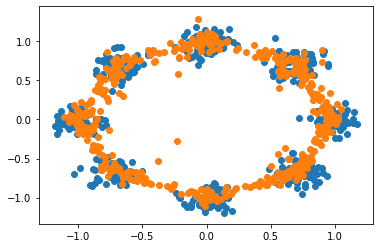

elbo: -7.752524375915527


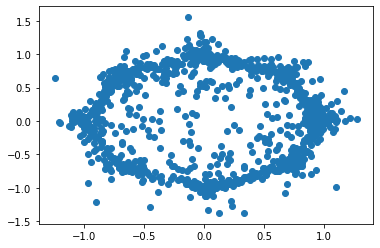

100%|██████████| 20001/20001 [12:16<00:00, 27.14it/s]


In [11]:
update_count = 0.0

if args.lrenc is None:
    lrenc = args.lrdec
else:
    lrenc = args.lrenc

if not args.learntransitions:
    for p in model.transitions.parameters():
        p.requires_grad_(False)
else:
    for k in range(len(model.transitions)):
        model.transitions[k].alpha_logit.requires_grad_(False)

if args.learnable_reverse:
    optimizer = torch.optim.Adam([
        {'params': model.target.decoder.parameters(), 'lr': args.lrdec},
        {'params': model.encoder.parameters()},
        {'params': model.transitions.parameters()},
        {'params': model.reverse_kernel.parameters()},
    ],
        lr=lrenc, weight_decay=args.l2_coeff)
else:
    optimizer = torch.optim.Adam([
        {'params': model.target.decoder.parameters(), 'lr': args.lrdec},
        {'params': model.encoder.parameters()},
        {'params': model.transitions.parameters()},
    ],
        lr=lrenc, weight_decay=args.l2_coeff)

for epoch in tqdm(range(args.n_epoches)):
    plt.close()
    for bnum, batch_train in enumerate(dataloader):

        if args.total_anneal_steps > 0:
            anneal = min(args.anneal_cap, 1. * update_count / args.total_anneal_steps)
        else:
            anneal = args.anneal_cap

        mu_recovered, log_q, log_aux, log_priors, log_r, sum_log_alpha, directions = model(batch_train)
#         pdb.set_trace()
        # loglikelihood part
        log_p = torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train)
        log_joint = log_p.mean() + log_priors.mean()
        # compute objective
        KLD = log_q.mean() + log_aux.mean() - log_r
        elbo_full = log_joint - anneal * KLD
        
        grad_elbo = elbo_full + elbo_full.detach() * torch.mean(sum_log_alpha)
        (-grad_elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
        
        #         pdb.set_trace()
        if (bnum % 200 == 0) and (epoch % print_info_ == 0):
            for k in range(args.K):
                print('k =', k)
                print('0: {} and for +1: {}'.format((directions[:, k] == 0.).to(float).mean(), (directions[:, k] == 1.).to(float).mean()))
                print('autoreg:', torch.sigmoid(model.transitions[k].alpha_logit.detach()).item())
                print('stepsize', torch.exp(model.transitions[k].gamma.detach()).item())
                print('-' * 100)

        update_count += 1
    if np.isnan(elbo_full.cpu().detach().mean().numpy()):
        break
    if epoch % print_info_ == 0:
        plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1])
        plt.scatter(mu_recovered.cpu().detach().numpy()[:, 0], mu_recovered.cpu().detach().numpy()[:, 1])
        plt.show();
        print('elbo:', elbo_full.cpu().detach().mean().item())
        
        z = np.random.randn(1000, 32).astype(np.float32)
        ds = model.target.decoder(torch.tensor(z, device=args.device)).cpu().detach().numpy()
        plt.scatter(ds[:, 0], ds[:, 1])
        plt.show();

### Posterior test

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import ncvis

In [13]:
N_rep = 2000

In [65]:
x_initial = torch.tensor([[0., 1.]], dtype=torch.float32, device=args.device)

In [66]:
x_initial.shape

torch.Size([1, 2])

In [67]:
mu, sigma = enc(x_initial) # sample mu and sigma from encoder
u = args.std_normal.sample((N_rep, mu.shape[1])) # sample random tensor for reparametrization trick
z_vae = mu + u * sigma # reperametrization trick
z_vae = z_vae.cpu().detach().numpy()

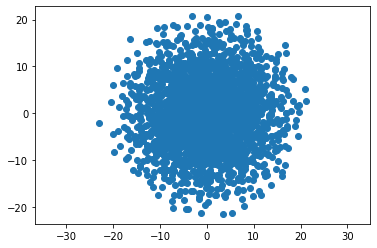

In [68]:
vis = ncvis.NCVis()
z_vae_proj = vis.fit_transform(z_vae)
plt.scatter(z_vae_proj[:, 0], z_vae_proj[:, 1])
plt.axis('equal');

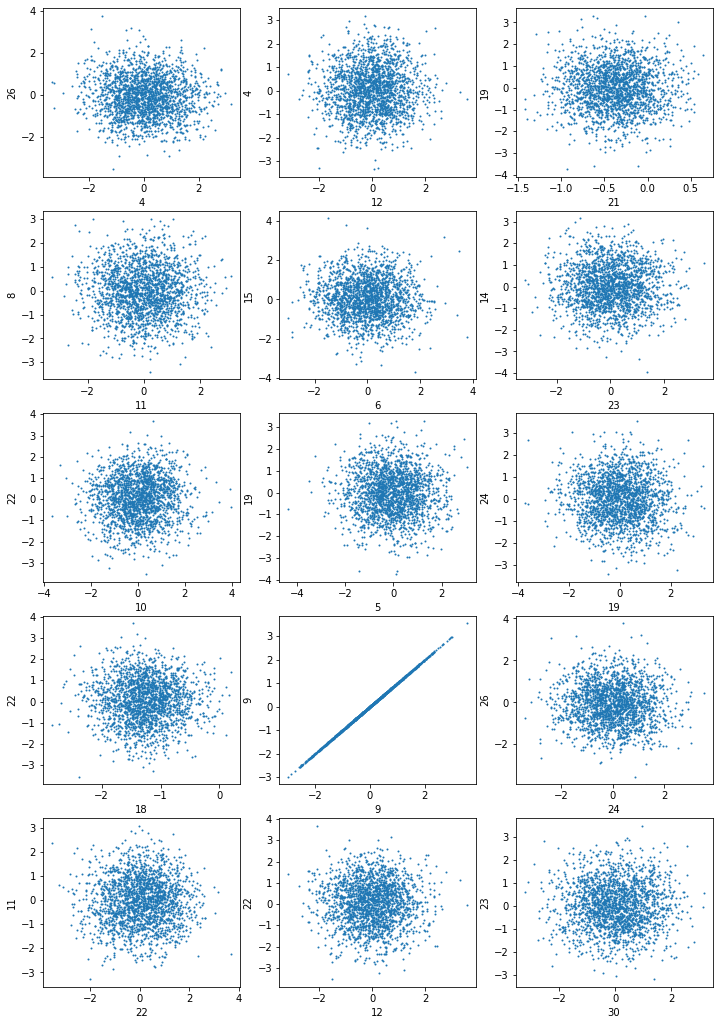

In [69]:
nrows = 5
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 18))
for i in range(nrows):
    for j in range(ncols):
        ax1, ax2 = np.random.randint(0, z_dim, 2)
        ax[i, j].scatter(z_vae[:, ax1], z_vae[:, ax2], s=1)
        ax[i, j].set_xlabel(ax1)
        ax[i, j].set_ylabel(ax2)

In [70]:
mu, std = model.encoder(x_initial)
u = model.std_normal.sample((N_rep, mu.shape[1]))
z = mu + u * std

p_old = model.std_normal.sample(z.shape)
p_ = p_old.detach()

for i in range(model.K):
    cond_vector = model.std_normal.sample(p_.shape)
    z, p_, _, _, _, _ = model.transitions[i].make_transition(q_old=z, x=x_initial.repeat((N_rep, 1)),
                                                                p_old=p_,
                                                                k=cond_vector,
                                                                target_distr=model.target)

z_metvae = z.cpu().detach().numpy()

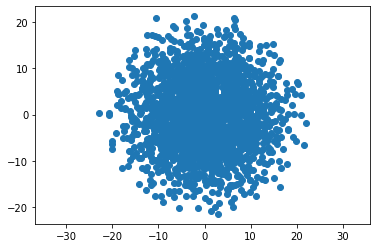

In [71]:
vis = ncvis.NCVis()
z_metvae_proj = vis.fit_transform(z_metvae)
plt.scatter(z_metvae_proj[:, 0], z_metvae_proj[:, 1])
plt.axis('equal');

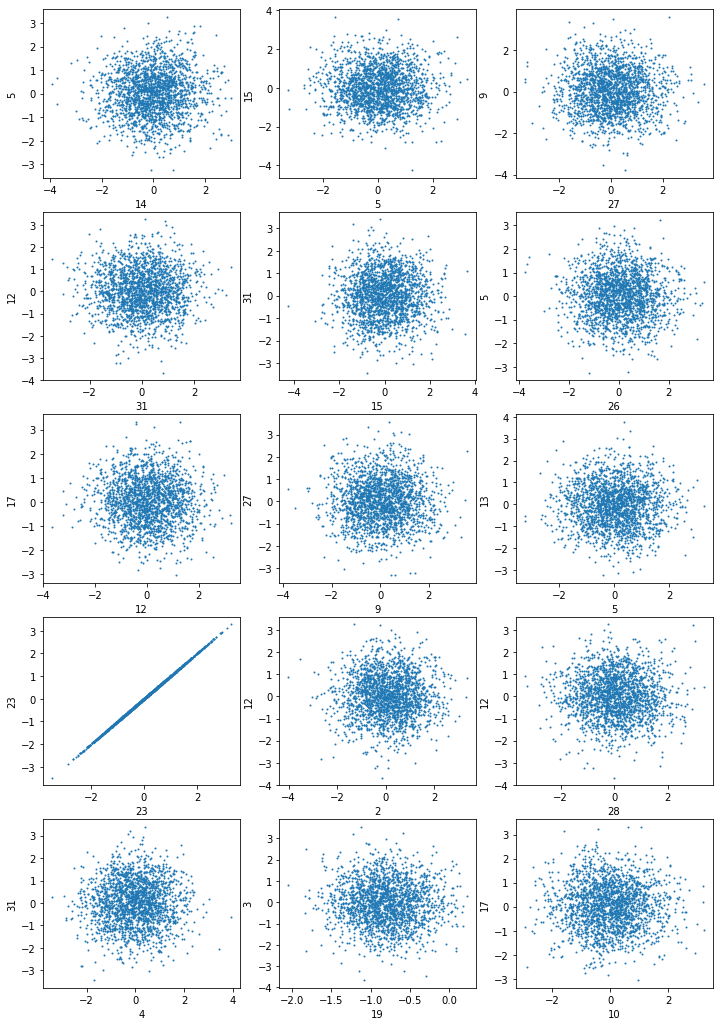

In [72]:
nrows = 5
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 18))
for i in range(nrows):
    for j in range(ncols):
        ax1, ax2 = np.random.randint(0, z_dim, 2)
        ax[i, j].scatter(z_metvae[:, ax1], z_metvae[:, ax2], s=1)
        ax[i, j].set_xlabel(ax1)
        ax[i, j].set_ylabel(ax2)

### HMC

In [73]:
from kernels import HMC_vanilla

In [74]:
class Target_test(nn.Module):
    def __init__(self, decoder, device='cpu'):
        super(Target_test, self).__init__()
        self.decoder = decoder
        self.prior = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                        scale=torch.tensor(1., device=device, dtype=torch.float32))
    def get_logdensity(self, z, x):
        mu_recovered = self.decoder(z)
        log_density = torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(x).sum(1) + self.prior.log_prob(z).sum(1)
        return log_density

In [75]:
target_vae = Target_test(dec, device=args.device).to(device=args.device)
for p in target_vae.parameters():
    p.requires_grad_(False)
target_our = Target_test(model.target.decoder, device=args.device).to(device=args.device)
for p in target_our.parameters():
    p.requires_grad_(False)

In [76]:
def run_hmc(target, x_initial):
    n_warmup = 5000
    n_samples = 1
    args.use_partialref = False
    args.N = 2
    transitions = HMC_vanilla(args)
    z = std_normal.sample((N_rep, z_dim))
    momentum = std_normal.sample(z.shape)
    
    print('Warm up')
    for i in tqdm(range(n_warmup)):
        z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=x_initial.repeat((N_rep, 1)))

    print('Sampling')
    for i in tqdm(range(n_samples)):
        z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=x_initial.repeat((N_rep, 1)))
    return z

In [ ]:
z_vae_hmc = run_hmc(target_vae, x_initial).cpu().detach().numpy()

  0%|          | 19/5000 [00:00<00:26, 189.00it/s]

Warm up


 64%|██████▎   | 3176/5000 [00:13<00:07, 245.30it/s]

In [ ]:
z_metvae_hmc = run_hmc(target_our, x_initial).cpu().detach().numpy()

In [ ]:
def print_plots(z, dec=None):
    vis = ncvis.NCVis()
    z_proj = vis.fit_transform(z)
    plt.scatter(z_proj[:, 0], z_proj[:, 1])
    plt.axis('equal')
    plt.show();

    nrows = 5
    ncols = 3
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 18))
    for i in range(nrows):
        for j in range(ncols):
            ax1, ax2 = np.random.randint(0, z_dim, 2)
            ax[i, j].scatter(z[:, ax1], z[:, ax2], s=0.5)
            ax[i, j].set_xlabel(ax1)
            ax[i, j].set_ylabel(ax2)
    plt.show();
    
    if dec:
        decoded_samples = dec(torch.tensor(z, device=args.device)).cpu().detach().numpy()
        plt.scatter(decoded_samples[:, 0], decoded_samples[:, 1])

In [ ]:
print_plots(z_vae_hmc, dec)

In [ ]:
print_plots(z_metvae_hmc, model.target.decoder)